In [7]:
import numpy as np
import time
import scipy
from scipy.optimize import minimize, NonlinearConstraint, BFGS
import matplotlib.pyplot as plt

import jax
from jax import lax
import jax.numpy as jnp
from jax import grad, jit, random
from pyscf import gto, scf

In [8]:
# Define molecule and basis set
mol = gto.Mole()
mol = gto.Mole()
mol.atom = [
    ["C", (-4.311, 2.521, -0.004)],
    ["C", (-3.416, 3.749, 0.023)],
    ["H", (-4.217, 1.948, 0.924)],
    ["H", (-4.054, 1.865, -0.841)],
    ["H", (-5.359, 2.818, -0.113)],
    ["C", (-1.944, 3.366, 0.164)],
    ["H", (-3.716, 4.394, 0.857)],
    ["H", (-3.563, 4.323, -0.900)],
    ["C", (-1.054, 4.595, 0.249)],
    ["H", (-1.635, 2.756, -0.693)],
    ["H", (-1.801, 2.757, 1.064)],
    ["H", (-1.146, 5.211, -0.651)],
    ["H", (-0.005, 4.298, 0.351)],
    ["H", (-1.317, 5.211, 1.115)]
    
    # ["C", (-4.301, 2.339, 0.081)],
    # ["C", (-3.707, 3.724, -0.107)],
    # ["H", (-4.018, 1.919, 1.052)],
    # ["H", (-3.958, 1.655, -0.702)],
    # ["H", (-5.394, 2.385, 0.037)],
    # ["C", (-2.189, 3.697, -0.049)],
    # ["H", (-4.090, 4.394, 0.670)],
    # ["H", (-4.028, 4.130, -1.073)],
    # ["H", (-1.841, 3.323, 0.919)],
    # ["H", (-1.786, 4.705, -0.189)],
    # ["H", (-1.778, 3.054, -0.834)]

    # ['O', (0.0, 0.0, 0.0)],
    # ['H', (0.0, -0.757, 0.587)],
    # ['H', (0.0, 0.757, 0.587)] 
    # ['O', (3.0, 0.0, 0.0)],
    # ['H', (3.0, -0.757, 0.587)],                                                                                                                       
    # ['H', (3.0, 0.757, 0)]

    # ['O', (0.0, 0.0, 0.0)],
    # ['H', (0.0, -0.757, 0.587)],
    # ['H', (0.0, 0.757, 0.587)]
    
    # ['C', (0.000000, 0.000000, 0.000000)],
    # ['H', (0.000000, 0.000000, 1.089000)],
    # ['H', (1.026719, 0.000000, -0.363000)],
    # ['H', (-0.513360, -0.889165, -0.363000)],
    # ['F', (-0.513360, 0.889165, -0.363000)]

    # ['N', (0.000000, 0.000000, 0.000000)],
    # ['H', (0.937700, 0.000000, -0.381600)],
    # ['H', (-0.468850, 0.812990, -0.381600)],
    # ['H', (-0.468850, -0.812990, -0.381600)]

    # ["C", (-2.818, 1.201, -0.000)],
    # ["H", (-3.183, 1.602, 0.948)],
    # ["H", (-3.182, 0.179, -0.126)],
    # ["H", (-3.183, 1.821, -0.822)],
    # ["H", (-1.726, 1.201, -0.000)]

    # ['C', (0.000000, 0.000000, -0.601100)],
    # ['C', (0.000000, 0.000000, 0.601100)],
    # ['H', (0.000000, 0.000000, -1.664500)],
    # ['H', (0.000000, 0.000000, 1.664500)]

    # ['C', (0.000000, 0.000000, 0.669500)],
    # ['C', (0.000000, 0.000000, -0.669500)],
    # ['H', (0.923000, 0.000000, 1.231000)],
    # ['H', (-0.923000, 0.000000, 1.231000)],
    # ['H', (0.923000, 0.000000, -1.231000)],
    # ['H', (-0.923000, 0.000000, -1.231000)]

    # ['C', (0.000000, 0.000000, 0.756400)],
    # ['C', (0.000000, 0.000000, -0.756400)],
    # ['H', (1.026719, 0.000000, 1.150700)],
    # ['H', (-0.513360, -0.889165, 1.150700)],
    # ['H', (-0.513360, 0.889165, 1.150700)],
    # ['H', (1.026719, 0.000000, -1.150700)],
    # ['H', (-0.513360, -0.889165, -1.150700)],
    # ['H', (-0.513360, 0.889165, -1.150700)]

    # ['C', (0.000000, 0.000000, 0.000000)],
    # ['O', (0.000000, 0.000000, 1.208000)],
    # ['H', (0.945221, 0.000000, -0.340000)],
    # ['H', (-0.945221, 0.000000, -0.340000)]
]
mol.unit = "angstrom"
mol.basis = 'cc-pVDZ'
mol.build()

# SCF calculation
mf = scf.RHF(mol)
energy = mf.kernel()
ao = mol.nao
nuclear_repulsion_energy = mol.energy_nuc()
print(f"Nuclear Repulsion Energy: {nuclear_repulsion_energy:.6f} Hartree")
print(f"Electron energy: {energy - nuclear_repulsion_energy:.6f} Hartree")
print("Number of basis functions:", ao)

# Compute one-electron integrals (overlap matrix, kinetic energy matrix, etc.)
S = mol.intor('int1e_ovlp')
T = mol.intor('int1e_kin')
V = mol.intor('int1e_nuc')
G = mol.intor('int2e')

H = T+V

converged SCF energy = -157.30933063795
Nuclear Repulsion Energy: 131.173669 Hartree
Electron energy: -288.483000 Hartree
Number of basis functions: 106


In [11]:
# Convert tensors to float32 JAX arrays
S = jnp.array(S, dtype=jnp.float32)
T = jnp.array(T, dtype=jnp.float32)
V = jnp.array(V, dtype=jnp.float32)
H = jnp.array(H, dtype=jnp.float32)
G = jnp.array(G, dtype=jnp.float32)
nuclear_repulsion_energy = jnp.float32(nuclear_repulsion_energy)

# Constants
Ne = mol.nelectron
occ_o = Ne // 2
num_repeats = 1
max_iter = 500
times = []

energies_buf = jnp.zeros((max_iter,))
constraints_buf = jnp.zeros((max_iter,))

# Define the orthogonality constraint
@jax.jit
def orthogonality(x, S):
    C = jnp.reshape(x, (ao, occ_o))
    temp = jnp.matmul(S, C)
    temp2 = jnp.matmul(C.T, temp)
    return jnp.linalg.norm(temp2 - jnp.eye(occ_o))


# Compute the energy
@jax.jit
def compute_energy(x, JK, H, S):
    C = jnp.reshape(x, (ao, occ_o))
    P = 2 * jnp.matmul(C, C.T)
    G = jnp.einsum('lk,ijkl->ij', P, JK) - 0.5 * jnp.einsum('lk,ilkj->ij', P, JK)
    e1 = jnp.einsum('ji,ij->', P, H)
    e2 = jnp.einsum('ji,ij->', P, G)
    energy = 0.5 * (2 * e1 + e2)
    return energy

# Compute the loss
@jax.jit
def compute_loss(x, JK, H, S, mu, lam):
    energy = compute_energy(x, JK, H, S)
    h = orthogonality(x, S)
    loss = energy + mu * h ** 2 + lam * h
    return loss

# Compute the gradient
@jax.jit
def compute_gradient(x, JK, H, S, mu, lam):
    grad_loss = jax.grad(compute_loss)
    return grad_loss(x, JK, H, S, mu, lam)


def armijo_line_search(x_curr, x_next, loss_curr, loss_next, d_curr, factor, alpha, JK, H, S, mu, lam):

    state = {
        'x': x_next,
        'loss': loss_next,
        'alpha': alpha,
    }

    def cond_fn(state):
        return state['loss'] > loss_curr + state['alpha']*factor

    def body_fn(state):
        x_next = x_curr + state['alpha'] * d_curr
        loss_next = compute_loss(x_next, JK, H, S, mu, lam)
        alpha = 0.5 * state['alpha']
        return {
            'x': x_next,
            'loss': loss_next,
            'alpha': alpha
        }

    final_state = lax.while_loop(cond_fn, body_fn, state)
    return final_state['x'], final_state['loss'], final_state['alpha']

@jax.jit
def run_secant_phase(x_curr, constraint, adapt_tol, coeff, mu, lam, JK, H, S):

    trace_energy = jnp.zeros(200)
    trace_constraint = jnp.zeros(200)
    
    def inner_cond(inner_state):
        grad_norm = jnp.linalg.norm(inner_state['grad'])
        y_norm = jnp.linalg.norm(inner_state['y_k'])
        return jnp.logical_and(
            grad_norm > inner_state['adapt_tol'],
            jnp.logical_and(y_norm > 1e-4, inner_state['iter'] < 1000)
        )

    def inner_body(inner_state):
        x_curr = inner_state['x']
        grad_curr = inner_state['grad']
        d_curr = inner_state['d']
        alpha = inner_state['alpha']
        mu = inner_state['mu']
        lam = inner_state['lam']
        
        loss_curr = compute_loss(x_curr, JK, H, S, mu, lam)
        x_next = x_curr + alpha * d_curr
        loss_next = compute_loss(x_next, JK, H, S, mu, lam)

        factor = 1e-4 * jnp.dot(grad_curr, d_curr)
        x_next, loss_next, alpha = armijo_line_search(x_curr, x_next, loss_curr, loss_next, d_curr, factor, alpha, JK, H, S, mu, lam)

        grad_next = compute_gradient(x_next, JK, H, S, mu, lam)

        # Secant step calculations
        s_k = x_next - x_curr
        y_k = grad_next - grad_curr
        s_k_sqr = jnp.dot(s_k, s_k)

        # Adaptive rho_k
        theta_k = 6 * (loss_curr - loss_next) + 3 * jnp.dot(grad_curr + grad_next, s_k)
        rho_k = lax.cond(
            s_k_sqr <= 1.0,
            lambda _: 1.0,
            lambda _: 0.0,
            operand=None
        )

        y_k_mod = lax.cond(
            theta_k > 0.0,
            lambda _: y_k + (rho_k * theta_k / s_k_sqr) * s_k,
            lambda _: y_k,
            operand=None
        )

        # Compute beta
        numerator1 = jnp.dot(grad_next, y_k_mod)
        numerator2 = 0.05 * jnp.dot(grad_next, s_k)
        denominator = jnp.dot(d_curr, y_k_mod)

        beta = lax.cond(
            denominator != 0.0,
            lambda _: jnp.maximum(numerator1 / denominator, 0.0) - numerator2 / denominator,
            lambda _: 0.0,
            operand=None
        )

        # jax.debug.print(
        #     "Iteration {}, Energy = {:.6f}, Constraint = {:.6f}, Loss = {:.6f}, mu = {:.3f}",
        #     inner_state['iter'],
        #     compute_energy(inner_state['x'], JK, H, S),
        #     orthogonality(inner_state['x'], S),
        #     compute_loss(inner_state['x'], JK, H, S, inner_state['mu'], inner_state['lam']),
        #     inner_state['mu']
        # )

        energy = compute_energy(x_next, JK, H, S)
        constraint = orthogonality(x_next, S)

        # Append to buffers
        energies_updated = jax.lax.dynamic_update_index_in_dim(
            inner_state['energies'], energy, inner_state['iter'], axis=0
        )
        constraints_updated = jax.lax.dynamic_update_index_in_dim(
            inner_state['constraints'], constraint, inner_state['iter'], axis=0
        )

        # Update direction and position
        d_next = -grad_next + beta * d_curr
        alpha = 0.75 * jnp.linalg.norm(s_k) / jnp.linalg.norm(d_curr)        
        
        return {
            'x': x_next,
            'grad': grad_next,
            'd': d_next,
            'alpha': alpha,
            'y_k': y_k,
            'iter': inner_state['iter'] + 1,
            'mu': mu,
            'lam': lam,
            'adapt_tol': inner_state['adapt_tol'],
            'energies': energies_updated,
            'constraints': constraints_updated
        }

    outer_state = {
        'x': x_curr,
        'constraint': constraint,
        'mu': mu,
        'lam': lam,
        'adapt_tol': adapt_tol,
        'coeff': coeff,
        'iter': 0,
        'energies': energies_buf,
        'constraints': constraints_buf
    }
    
    def outer_cond(state):
        return state['constraint'] > 1.0

    def outer_body(state):
        # Initialize inner state
        grad_curr = compute_gradient(state['x'], JK, H, S, state['mu'], state['lam'])
        inner_state = {
            'x': state['x'],
            'grad': grad_curr,
            'd': -grad_curr,
            'alpha': 0.05,
            'y_k': jnp.ones_like(state['x']),
            'iter': state['iter'],
            'mu': state['mu'],
            'lam': state['lam'],
            'adapt_tol': state['adapt_tol'],
            'energies': state['energies'],
            'constraints': state['constraints']
        }

        final_inner = lax.while_loop(inner_cond, inner_body, inner_state)

        # Update constraint and multipliers
        x_curr = final_inner['x']
        constraint = orthogonality(x_curr, S)
        mu = state['mu'] * 2.0
        lam = state['lam'] + 2.0 * state['mu'] * constraint
        adapt_tol = 0.5 * jnp.exp(-state['coeff'] * mu)

        return {
            'x': final_inner['x'],
            'constraint': constraint,
            'mu': mu,
            'lam': lam,
            'adapt_tol': adapt_tol,
            'coeff': state['coeff'],
            'iter': final_inner['iter'],
            'energies': final_inner['energies'],
            'constraints': final_inner['constraints'],
        }

    final_state = lax.while_loop(outer_cond, outer_body, outer_state)
    return final_state['x'], final_state['constraint'], final_state['adapt_tol'], final_state['mu'], final_state['lam'], final_state['iter'], final_state['energies'], final_state['constraints']


def run_trust_constr_phase(x_curr, JK, H, S):

    def orthogonality_vec(x):
        C = jnp.reshape(x, (ao, occ_o))
        temp = jnp.matmul(S, C)
        temp2 = jnp.matmul(C.T, temp)
        temp3 = temp2 - jnp.eye(occ_o)
        return temp3.flatten()

    def orthogonality_jacobian(x):
        return np.asarray(jax.jacobian(orthogonality_vec)(jnp.array(x)))
    
    def objective(x):
        return float(compute_energy(jnp.array(x), JK, H, S))
    
    def objective_grad(x):
        return np.asarray(jax.grad(compute_energy)(jnp.array(x), JK, H, S))

    tr_constraints = []
    tr_energies = []

    def trust_callback(xk, state):
        constraint = float(orthogonality(xk, S))
        tr_constraints.append(constraint)
        tr_energies.append(compute_energy(xk, JK, H, S))
    
    nonlin_constr = NonlinearConstraint(
        fun=orthogonality_vec,
        lb=0.0, ub=0.0,
        jac=orthogonality_jacobian,
    )
    
    res = minimize(
        fun=objective,
        jac=objective_grad,
        x0=x_curr,
        method='trust-constr',
        constraints=[nonlin_constr],
        callback=trust_callback,
        hess=BFGS(),
        options={
            'verbose': 0,
            'maxiter': 1000,
            'gtol': 1e-4, # Gradient norm tolerance
            'xtol': 1e-5, # Terminates if the change in x is too small
            'barrier_tol': 1e-5, # tolerance for constraint violation
            #'factorization_method': 'SVDFactorization'
        }
    )
    
    return res.x, res.nit, orthogonality(res.x, S), tr_constraints, tr_energies


def hybrid_optimization(JK, H, S, mu, lam, x0=None):
    adapt_tol = 1.0
    coeff = 0.001
    tol_grad_change = 1e-4

    start_time = time.time()

    # Initialization
    if x0 is None:
        key = jax.random.PRNGKey(0)
        x_curr = jax.random.uniform(key, (ao * occ_o,), minval=0.0, maxval=0.1)
    else:
        x_curr = x0
    constraint = orthogonality(x_curr, S)

    print("Starting Secant Phase...")
    x_curr, constraint, adapt_tol, mu, lam, iteration_secant, secant_energies, secant_constraints = run_secant_phase(x_curr, constraint, adapt_tol, coeff, mu, lam, JK, H, S)

    energies = secant_energies[:iteration_secant]
    secant_constraints = secant_constraints[:iteration_secant]

    # Trust Regions Phase
    print("Switching to trust regions constrained optimization phase...")
    x_curr, iteration_tr, constraint, tr_constraints, tr_energies = run_trust_constr_phase(x_curr, JK, H, S)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Optimization completed in {iteration_secant} Secant iterations and {iteration_tr} TR iterations.")
    print(f"Final Energy: {compute_energy(x_curr, JK, H, S):.6f}, Constraint: {orthogonality(x_curr, S):.8f}")
    print(f"Elapsed time: {elapsed_time:.4f} seconds")

    return x_curr, iteration_secant + iteration_tr, elapsed_time, energies, secant_constraints, tr_constraints, tr_energies


# Test the hybrid gradient optimization
results = []
times = []
for _ in range(num_repeats):
    for i in range(5):
        key = jax.random.PRNGKey(i)
        x0 = jax.random.uniform(key, (ao * occ_o,), minval=-0.1, maxval=0.1)
        
        mu = 1.0
        lam = 0.0
    
        optimized_x, iterations, elapsed_time, secant_energies, secant_constraints, tr_constraints, tr_energies = hybrid_optimization(G, H, S, mu, lam, x0=x0)
    
        results.append({
            "seed": i,
            "secant_energies": secant_energies,
            "tr_energies": tr_energies
        })
    times.append(elapsed_time)

average_time = sum(times[:]) / len(times[:])
print(f"Average time: {average_time:.4f} seconds")
scf_energy = compute_energy(optimized_x, G, H, S)+nuclear_repulsion_energy
print(f"SCF energy: {scf_energy:.4f}")

Starting Secant Phase...
Switching to trust regions constrained optimization phase...
Optimization completed in 163 Secant iterations and 116 TR iterations.
Final Energy: -288.481293, Constraint: 0.00000066
Elapsed time: 28.0956 seconds
Starting Secant Phase...
Switching to trust regions constrained optimization phase...
Optimization completed in 162 Secant iterations and 116 TR iterations.
Final Energy: -288.480438, Constraint: 0.00000060
Elapsed time: 25.6003 seconds
Starting Secant Phase...
Switching to trust regions constrained optimization phase...
Optimization completed in 158 Secant iterations and 143 TR iterations.
Final Energy: -288.480774, Constraint: 0.00000065
Elapsed time: 30.7009 seconds
Starting Secant Phase...
Switching to trust regions constrained optimization phase...
Optimization completed in 156 Secant iterations and 122 TR iterations.
Final Energy: -288.480957, Constraint: 0.00000059
Elapsed time: 25.0829 seconds
Starting Secant Phase...
Switching to trust regions 

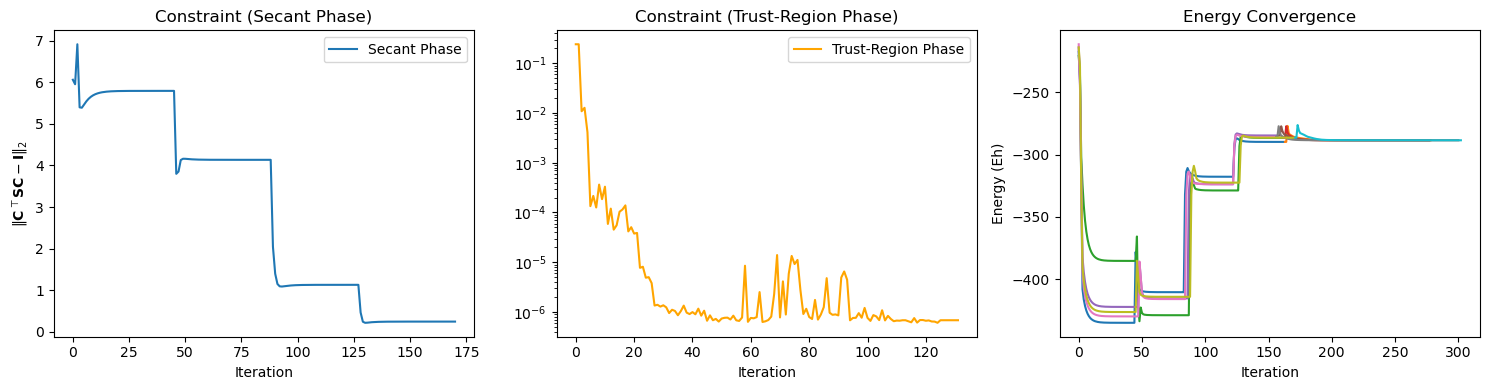

In [12]:
# First two plots: single-run constraints
iterations_sec = list(range(len(secant_constraints)))
iterations_tr = list(range(len(tr_constraints)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Secant Phase Constraint (linear scale)
ax1.plot(iterations_sec, secant_constraints, label='Secant Phase')
ax1.set_xlabel('Iteration')
ax1.set_ylabel(r'$\|\mathbf{C}^\top \mathbf{S} \mathbf{C} - \mathbf{I}\|_2$')
ax1.set_title('Constraint (Secant Phase)')
ax1.legend()

# Plot 2: Trust-Region Phase Constraint (log scale)
ax2.plot(iterations_tr, tr_constraints, label='Trust-Region Phase', color='orange')
ax2.set_yscale('log', base=10)
ax2.set_xlabel('Iteration')
ax2.set_title('Constraint (Trust-Region Phase)')
ax2.legend()

# Plot 3: Total Energy over both phases
for i in range(len(results)):
    secant_energies = results[i]["secant_energies"]
    tr_energies = results[i]["tr_energies"]
    
    iterations_sec = list(range(len(secant_energies)))
    iterations_tr = [j + len(secant_energies) for j in range(len(tr_energies))]
    
    ax3.plot(iterations_sec, secant_energies, label=f'Secant Phase {i+1}')
    ax3.plot(iterations_tr, tr_energies, label=f'Trust Phase {i+1}')

ax3.set_xlabel('Iteration')
ax3.set_ylabel('Energy (Eh)')
ax3.set_title('Energy Convergence')

plt.tight_layout()
plt.show()